# Анализ оттока клиентов банка «Метанпром»

**Задача:**

Определить сегменты клиентов, которые склонны уходить из банка.

**Заказчик:** отдел маркетинга банка «Метанпром»

**Данные:** 
Датасет [bank_scrooge.csv](https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F) с данными о клиентах банка «Метанпром».
Колонки:

- `USERID` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `city` — город,
- `gender` — пол,
- `age` — возраст,
- `equity`  — количество баллов собственности
- `balance` — баланс на счёте,
- `products` — количество продуктов, которыми пользуется клиент,
- `credit_card` — есть ли кредитная карта,
- `last_activity` — активный клиент,
- `Est_salary` — заработная плата клиента,
- `churn` — ушёл или нет.

<a id="enter"></a>

**Содержание:**
1. [Предобработка данных](#first)
2. [Исследовательский анализ данных (EDA)](#eda)
3. [Итоги по EDA](#icon)
4. [Сегментация признаков](#segm)
5. [Общие выводы](#concl)

**Описание этапов работы:**

Для выполнения задачи проекта по разделам сделано следущее:

```
        1. Предобработка данных:
        
 - Загрузка данных      
 - Перевод заголовков столбцов в нужный формат
 - Проверка типов данных
 - Поиск дубликатов в датафрейме
 - Изучение и обработка пропусков в датафрейме с объяснением причины
 - Изучение категориальных и количественных значений
 - Добавление столбцов категорий по полу и городам запоненных через фиктивную переменную     

        2. Исследовательский анализ:
- Определение типичного портрета клиента и отточного
- Определение параметров, при которых относительный отток превышает общий отток.
- Расчет корреляции столбца churn со всеми признаками датафрейма.
- Отбор наиболее многочисленных по оттоку признаков.

        3. Проверка гипотез:
- Формулирока гипотез по каждому признаку
- Тестирования гипотез
- Уточнение признаков влияющих на отток 

        4. Сегментация признаков
- Выбор наиболее выраженных сегметов на основе полученных признаков 

        5. Общие выводы
 ```      

**Библиотеки, используемые в проекте**

In [1]:
!pip install phik --quiet

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.ticker as ticker
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.proportion import proportions_ztest
import sys
from scipy import stats as st
import phik
import math as mth

**Функции, используемые в проекте**

In [3]:
# график для пропусков в столбце balance
def sp_pl (f, col, tip):
    f.query('balance.isna()')[col].value_counts().sort_index().plot(kind=tip, color='r', label='пропуски')
    df[col].value_counts().sort_index().plot(kind=tip,
                                      label='количество клиентов', alpha=0.5)
    plt.grid()
    plt.legend()
    plt.ylabel('Количество пропусков/клиентов');    
# график плотностей kde
def dens_kde (f, a, axes, mi, ma):
    f[a].plot.kde(
               title = f"{a}", 
               ax = axes, xlim=([mi, ma]), label='сумма', legend=True,
             fontsize=16)
    f.query('churn==1')[a].plot.kde( 
               ax = axes, color='r', xlim=([mi, ma]), label='отток', legend=True,
             fontsize=16)
    axes.grid()
    plt.tight_layout()
    
# график плотностей hist  
def dens_hist (f, a, axes, b):
    f.query('churn==1')[a].hist(ax = axes, color='r', density=True, label='отток', bins=b)
    f[a].hist(ax = axes, density=True, label='сумма', alpha=0.5, bins=b)
    axes.set_title(a)
    plt.tight_layout()
    
# столбчатый график
def bar_plot (a, ax):
    df.groupby(a)['churn'].mean().plot(kind='bar', x='index', y='mean', ax=ax, fontsize=16).set_title(a,
                        fontsize=22, color='SteelBlue')
    for i in ax.patches:
        ax.text(i.get_x()+i.get_width()/2.,
             i.get_height()+0.001,
             str(round((i.get_height()), 2)),
             ha='center',
             fontsize=16)
    ax.axhline(y = df['churn'].mean(), color = 'r', linestyle = '-')
    ax.text(0.2, 0.2,'{}'.format(round(df['churn'].mean(), 2)), rotation=360, fontsize=16);    
# z-тест
def z_test(a):
    alpha=0.05
    successes = np.array([df1[df1['churn']==0][a].sum(), df1[df1['churn']==1][a].sum()])
    trials = np.array([df1[df1['churn']==0][a].count(), df1[df1['churn']==1][a].count()])
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1-p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

[к содержанию](#enter)

<a id='first'></a>
## Предобработка данных

### Знакомство с данными

In [4]:
path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F" 
df = pd.read_csv(path)

In [5]:
df.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Как видно из описания, датафрейм состоит из 10000 строк и 12 столбцов. Типы данных соответствуют содержимому. Все столбцы кроме `age` и `balance` не содержат пропусков. Рассмотри далее на распределение данных в каждом столбце.

In [7]:
df.describe()

,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,10000.00000,10000.000000,9974.000000,10000.000000,7.705000e+03,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,171814.71260,848.699400,42.734409,2.627600,8.277943e+05,1.870100,0.680400,0.523500,1.478669e+05,0.182000
std,33708.23812,65.448519,12.179971,1.980836,1.980614e+06,0.792647,0.466345,0.499472,1.393885e+05,0.385864
min,94561.00000,642.000000,18.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142810.25000,802.000000,33.000000,0.000000,2.955542e+05,1.000000,0.000000,0.000000,7.525190e+04,0.000000
50%,172728.00000,853.000000,40.000000,3.000000,5.242722e+05,2.000000,1.000000,1.000000,1.196581e+05,0.000000
75%,201261.75000,900.000000,51.000000,4.000000,9.807058e+05,2.000000,1.000000,1.000000,1.745005e+05,0.000000
max,229145.00000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000


<AxesSubplot:>

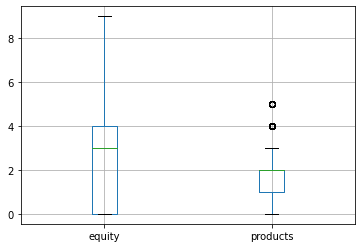

In [8]:
df[['equity', 'products']].boxplot()

Как из диаграммы оценка собственности составляет от 0 до 9, медиана равна 3. По колицеству продуктов данные изменяются от 0 до 5.  C нулем всего одно значение у бывшего клиента банка. Остальные сосредоточены от 1 до 3, 2 - в среднем, а 4 и 5 встречается намного реже.

In [9]:
df[df['products']==0]

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
8957,147837,962.0,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1


In [10]:
df = df[df['products']!=0]

<AxesSubplot:>

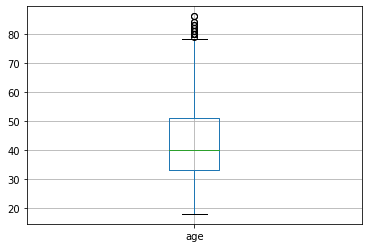

In [11]:
df[['age']].boxplot()

Возраст клиентов составляет от 18 до 86, из которых основная масса имеет возраст от 18 до 78. Средний возраст - 40 лет.

<AxesSubplot:>

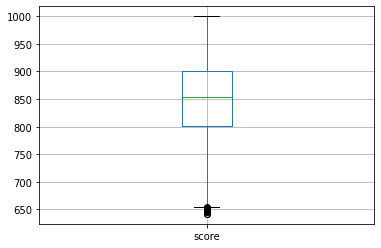

In [12]:
df[['score']].boxplot()

Оценка надежности изменяется от 642 до 1000, 853 -в среднем. От 642 до 655 - выбросы.

<AxesSubplot:>

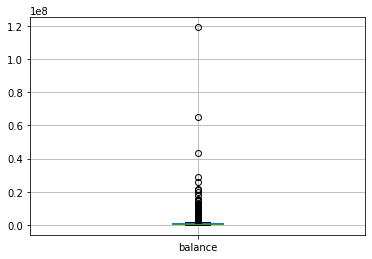

In [13]:
df[['balance']].boxplot()

По балансу видно, что наблюдается значительный разброс, стандартное отклонение превышает среднее. на счету в основном от 0 до 2 млн., медиана - 524 тыс., максимум - 119 млн.

<AxesSubplot:>

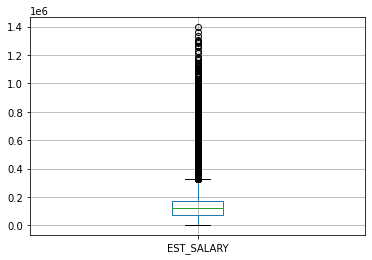

In [14]:
df[['EST_SALARY']].boxplot()

В столбце зарплат тоже много выбросов. Основной диапазон это 2546 - 323 тыс., медиана - 120 тыс., максимум - 1.4 млн.

### Поиск дубликатов

`Проверка на явные дубликаты`

In [15]:
df.duplicated().unique()

array([False])

Явных дубликатов нет

`Проверка на неявные дубликаты`

In [16]:
df['city'].unique()

array(['Рыбинск', 'Ярославль', 'Ростов'], dtype=object)

В столбце `city` 3 уникальных названия городов, поэтому неявных дубликатов нет

In [17]:
print(*sorted(df['age'].unique()), sep=", ")

18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, nan, 81.0, 82.0, 83.0, 84.0, 86.0


В столбце `age` неявных дубликатов нет

In [18]:
df['gender'].unique()

array(['Ж', 'М'], dtype=object)

В столбце `gender` неявных дубликатов нет

In [19]:
df['equity'].unique()

array([1, 5, 0, 4, 3, 2, 6, 7, 8, 9])

В столбце `equity` неявных дубликатов нет

In [20]:
df['products'].unique()

array([2, 3, 1, 4, 5])

В столбце `products` неявных дубликатов нет

In [21]:
df['last_activity'].unique()

array([1, 0])

В столбце `last_activity` неявных дубликатов нет

In [22]:
df['churn'].unique()

array([1, 0])

В столбце `churn` неявных дубликатов нет

In [23]:
len(df['USERID'].unique())

9926

In [24]:
df['USERID'].duplicated().unique()

array([False,  True])

In [25]:
len(df['USERID'])-len(df['USERID'].unique())

73

В столбце 'USERID' 73 дубликата, удалим

In [26]:
df = df[~df['USERID'].duplicated()]

In [27]:
df['USERID'].duplicated().unique()

array([False])

### Преобразование данных

`Приведение названий столбцов к нижнему регистру`

In [28]:
df = df.rename(columns={'USERID': 'userid', 'EST_SALARY': 'salary'})

`Создание столбцов из gender и city`

Для удобства дальнейшего исследования создадим копии столбцов `city` и `gender`

In [29]:
df['all_cities'] = df['city']

In [30]:
df['all_genders'] = df['gender']

Перекодируем столбцы `city` и `gender` через фиктивную переменную

In [31]:
df = pd.get_dummies(df, columns=['city', 'gender'])

Переименуем названия новых столбцов

In [32]:
df = df.rename(columns={'city_Ростов': 'rostov', 'city_Рыбинск': 'rybinsk',
            'city_Ярославль': 'yaroslavl', 'gender_Ж': 'female', 'gender_М': 'male'})

`Обработка пропусков`

Пропуски в данных принято относить к одной из трёх категорий:
- MCAR (Missing Completely At Random / Отсутствует совершенно случайно) — пропуски не зависят от переменных и не ведут к систематической ошибке (смещение, bias), но увеличивают случайную ошибку (разброс, variance), можно их отбрасывать или заполнять, т.к. заполнение не повлияет на характер связи между заполняемой переменной и остальными.
- MAR (Missing At Random / Отсутствует случайно) — в рамках каждой из групп, которая есть в описываемой данными совокупности, распределение пропусков случайно, можно их отбрасывать.
- MNAR (Missing Not At Random / Отсутствует не случайно) — пропуски зависят от переменных, которых нет в данных, объяснить взаимосвязи с данными не получается, без дополнительного обоснования их нельзя отбрасывать или заполнять одним значением, т.к. это приведёт к заметным искажениям.

Столбец `age` содержит 9974 заполненных строк, что составлет 99,7% от общего количества. Такое незначительное количество пропусков скорее всего случайность. Заполним их медианами.

In [33]:
df=df.fillna({'age':df['age'].median()})

Столбец `balance` содержит 7705 заполненных строк, что составлет 77% от общего количества, поэтому пропуски могут быть как случайными так и нет.

Рассмотрим распределение пропусков по городам

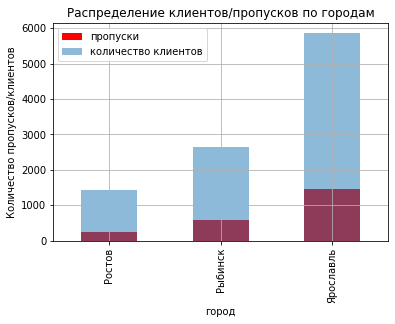

In [34]:
sp_pl(df, 'all_cities', 'bar')
plt.title('Распределение клиентов/пропусков по городам')
plt.xlabel('город');

В Ярославле доля пропусков составляет 64%, общая доля - 59%, а в Рыбинске и Ростове доля пропусков ниже чем общая доля на 1 и 4%. Соотношения довольно близкие, поэтому различие в распределении пропусков здесь неслучайно, чем больше клиентов, тем больше пропусков.

Рассмотрим распределение пропусков по количеству продуктов

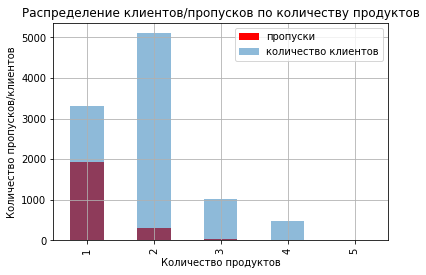

In [35]:
sp_pl(df, 'products', 'bar')
plt.title('Распределение клиентов/пропусков по количеству продуктов')
plt.xlabel('Количество продуктов');

Здесь видно, что больше всего клиентов используют 2 продукта, но максимальное число пропусков у клиентов с 1 продуктом. Такой результат также можно объяснить, клиенты у которых например есть кредит вряд ли имеют ещё и депозит. 

Рассмотрим распределение пропусков по оценке собственности

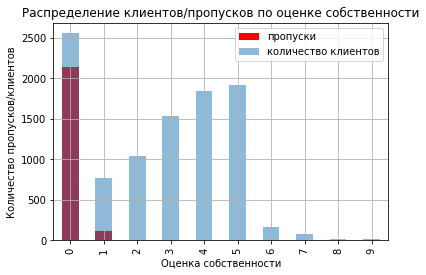

In [36]:
sp_pl(df, 'equity', 'bar')
plt.title('Распределение клиентов/пропусков по оценке собственности')
plt.xlabel('Оценка собственности');

Результат также закономерен где нет средств там и нет собственности.

Рассмотрим распределение пропусков по наличию кредитной карты

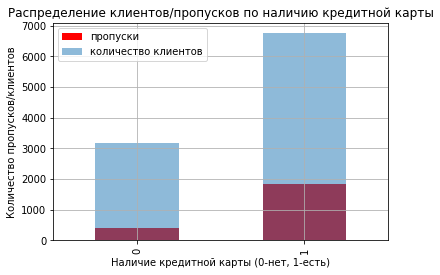

In [37]:
sp_pl(df, 'credit_card', 'bar')
plt.title('Распределение клиентов/пропусков по наличию кредитной карты')
plt.xlabel('Наличие кредитной карты (0-нет, 1-есть)');

Тут также все очевидно, кредитной картой в основном пользуются те у кого нет собственных средств. 

Рассмотрим распределение пропусков по возрасту

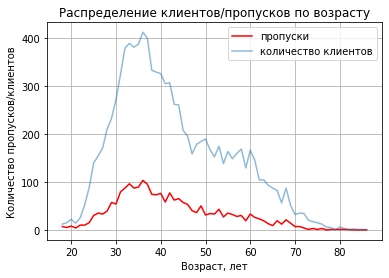

In [38]:
sp_pl(df, 'age', 'line')
plt.title('Распределение клиентов/пропусков по возрасту')
plt.xlabel('Возраст, лет');

Как видно распределение по возрасту и тут неслучайно, где больше общее количество там и пропусков больше

Рассмотрим распределение пропусков по полу

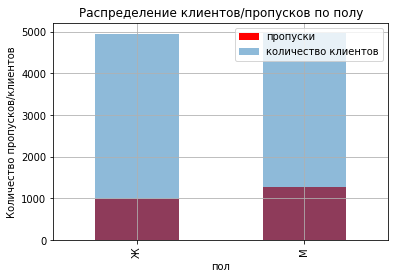

In [39]:
sp_pl(df, 'all_genders', 'bar')
plt.title('Распределение клиентов/пропусков по полу')
plt.xlabel('пол');

Общее соотношение мужчин и женщин примерно одинаковое, а в пропусках мужчин немного больше (это скорее случайно).

Рассмотрим распределение пропусков по скорингу

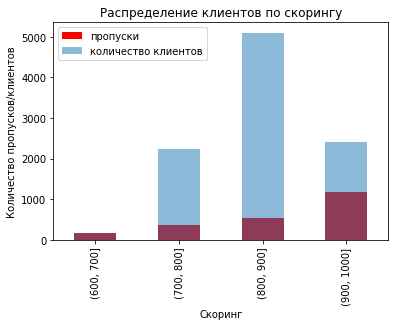

In [40]:
df.query('balance.isna()')['userid'].groupby(pd.cut(df.query('balance.isna()')['score'], np.arange(600, 1100, 100))
                                            ).count().plot(kind='bar', color='r', label='пропуски')
df['userid'].groupby(pd.cut(df['score'], np.arange(600, 1100, 100))).count().plot(kind='bar',
                                      label='количество клиентов', alpha=0.5)
plt.legend()
plt.title('Распределение клиентов по скорингу')
plt.xlabel('Скоринг')
plt.ylabel('Количество пропусков/клиентов');

Интересный результат получился больше всего пропусков у самых надежных клиентов, меньше всего у ненадежных. Если брать по относительной величине, у самых ненадежных клиентов (600-700) соотношение пропусков к общему количеству почти 100% (правда их немного), а у самых надежных клиентов соотношение пропусков к общему количеству около 50%. Минимальное соотношение в интервале (800-900) - примерно 10%.

Рассмотрим распределение пропусков по активности

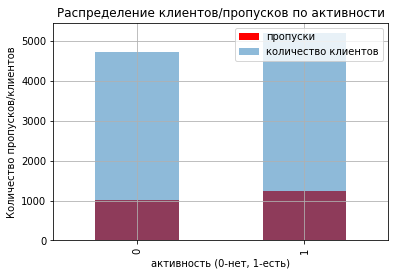

In [41]:
sp_pl(df, 'last_activity', 'bar')
plt.title('Распределение клиентов/пропусков по активности')
plt.xlabel('активность (0-нет, 1-есть)');

Как видно пропуски не связаны с активностью.

Рассмотрим распределение пропусков по зарплате

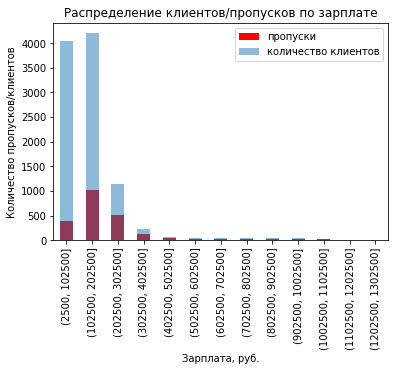

In [42]:
df.query('balance.isna()')['userid'].groupby(pd.cut(df.query('balance.isna()')['salary'],
              np.arange(2500, 1400000, 100000))).count().plot(kind='bar', color='r', label='пропуски')
df['userid'].groupby(pd.cut(df['salary'],
              np.arange(2500, 1400000, 100000))).count().plot(kind='bar',
                                      label='количество клиентов', alpha=0.5)
plt.legend()
plt.title('Распределение клиентов/пропусков по зарплате')
plt.xlabel('Зарплата, руб.')
plt.ylabel('Количество пропусков/клиентов');

Больше всего пропусков (1037) при зарплатах от 100 до 200 тыс., а до 100 тыс - в 2,6 раза меньше, хотя общее количество сопоставимо. Учитывая это и общий разброс предположу что и здесь пропуски не связаны с зарплатой.

Таким образом, столбец `balance` имеет пропуски не случайно и поэтому его решено оставить без изменений

<a id='eda'></a>

## Исследовательский анализ данных

### Портрет типичных и выбывших клиентов банка.

In [43]:
pic=(df[['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'salary', 'churn',
     'rostov', 'rybinsk', 'yaroslavl', 'female', 'male']].mean().round(1).reset_index()).merge(
(df.query('churn==1')[['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'salary', 'churn',
     'rostov', 'rybinsk', 'yaroslavl', 'female', 'male']].mean().round(1).reset_index()),
on='index')

In [44]:
pic=pic.rename(columns={'index': 'cat_name', '0_x': 'all_clients', '0_y': 'churn_clients'})
pic['delta'] = ((1-pic['churn_clients']/pic['all_clients'])*100).round(1)

In [45]:
display(pic.query('cat_name!="churn"').sort_values(by='delta', key=abs))

,cat_name,all_clients,churn_clients,delta
9,rostov,0.1,0.1,0.0
11,yaroslavl,0.6,0.6,0.0
7,salary,147903.8,148310.7,-0.3
0,score,848.7,863.3,-1.7
1,age,42.7,41.4,3.0
5,credit_card,0.7,0.6,14.3
4,products,1.9,2.4,-26.3
10,rybinsk,0.3,0.2,33.3
3,balance,828901.6,1133993.3,-36.8
6,last_activity,0.5,0.7,-40.0


Для типичного клиента банка характерно следующее:
```
возраст - 43 года
скоринг - 849
показатель собственности - 2.6
баланс на счету - 830 тыс.
количество банковских продуктов - 2
кредитная карта - +
зарплата - 148 тыс.
город - Ярославль

```
Для отточного клиента банка характерно следующее:
```
возраст - 41 год
скоринг - 863
показатель собственности - 3.8
баланс на счету - 1.13 млн.
количество банковских продуктов - 2
кредитная карта - +
активность - +
зарплата - 148 тыс.
город - Ярославль
пол - мужской

```

По предварительной оценке показатели по которым отличие отточных и действующих клиентов составляет > 10%:
 - у отточных выше: 
                    `equity`  на 46.2%, 
                    `balance` на 37.0%, 
                    `products` на 26.3%, 
                    `last_activity` на 40.0%, 
                    `male` на 20.0%
 - у отточных ниже: 
                    `credit_card` на 14.3%, 
                    `rybinsk` на 33% 

### Определение значений, при которых относительный отток превышает общие показатели.

Построим графики для непрерывных значений

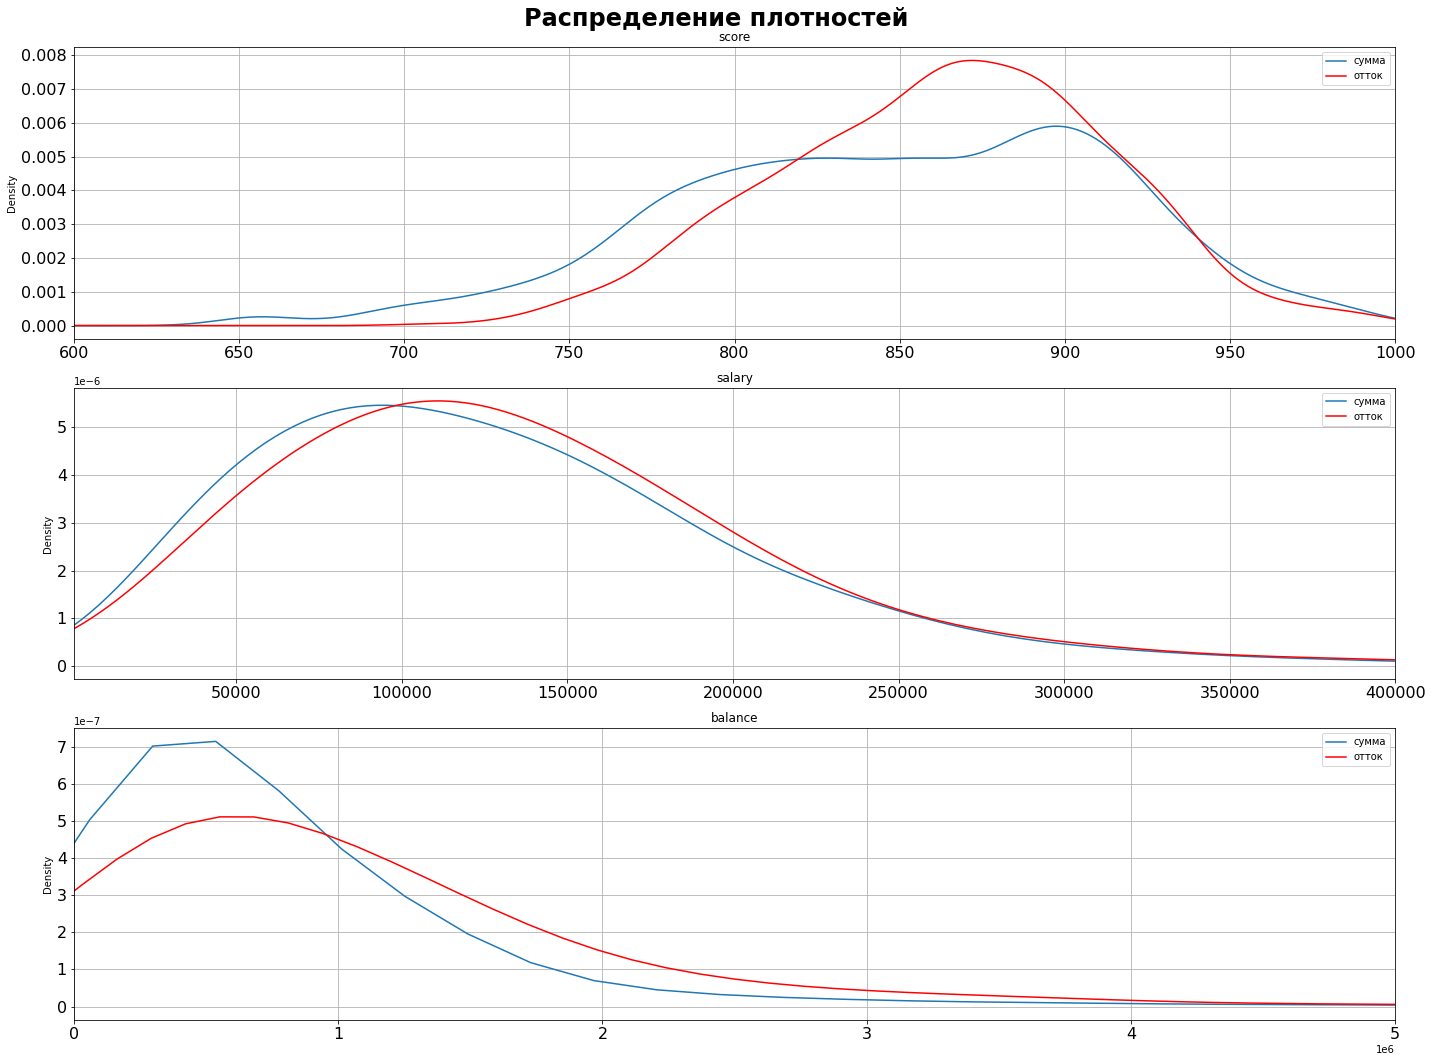

In [46]:
fig, axes = plt.subplots(3, 1, figsize = (20,15))
fig.suptitle('Распределение плотностей', fontsize = 24, fontweight='bold')
dens_kde(df, 'score', axes[0], 600, 1000)
dens_kde(df, 'salary', axes[1], 1000, 400000)
dens_kde(df, 'balance', axes[2], 0, 5000000);


Как видно из графиков отток выше на следующих участках:
```
- по скорингу - 820-940;
- по зарплатам - 100-250 тыс.;
- по балансу на счете - 1-4 млн.
```

Построим гистограммы для дискретных значений

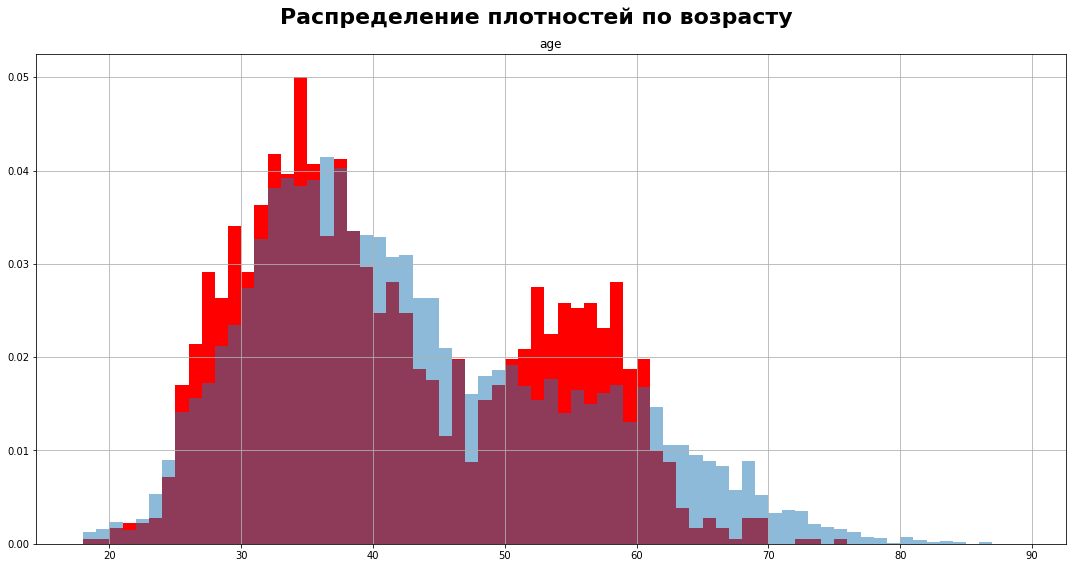

In [47]:
fig, axes = plt.subplots(1, 1, figsize = (15,8))
fig.suptitle('Распределение плотностей по возрасту', fontsize = 22, fontweight='bold')
dens_hist(df, 'age', axes, range(18,90))

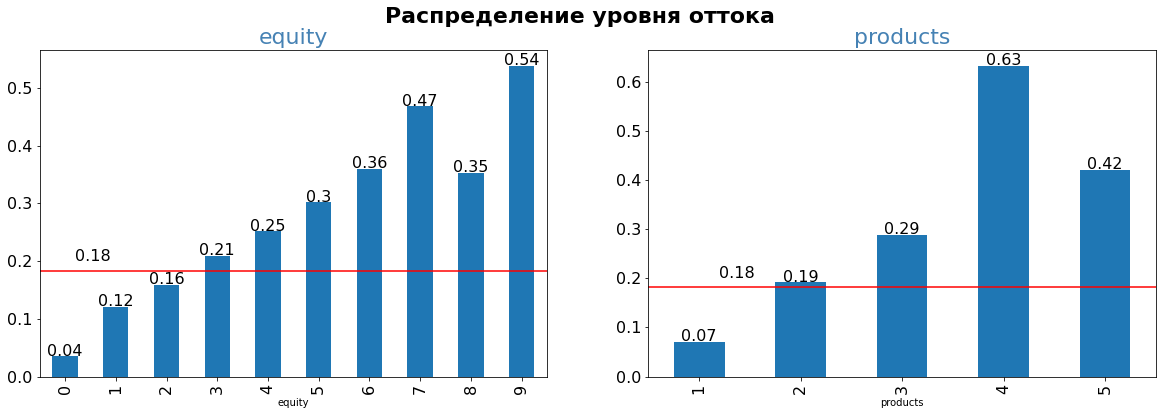

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('Распределение уровня оттока', fontsize = 22, fontweight='bold')
bar_plot('equity', ax[0])
bar_plot('products', ax[1])

Из графиков следует что отток выше на следующих участках:
```
- по возрасту - 25-35 и 50-61;
- по оценке собственности - > 2;
- по количеству банковских продуктов - > 1
```

Построим гистограммы для бинарных значений

In [49]:
cat_gr = pd.DataFrame([0, 1]) 
for i in ['credit_card', 'last_activity', 'rostov', 'rybinsk',
            'yaroslavl', 'female', 'male']:
    cat_gr = cat_gr.join(df.groupby(i)[['churn']].mean().reset_index(drop=True).rename(columns={'churn': i}))
cat_gr = cat_gr.drop(columns=0).T.reset_index()    


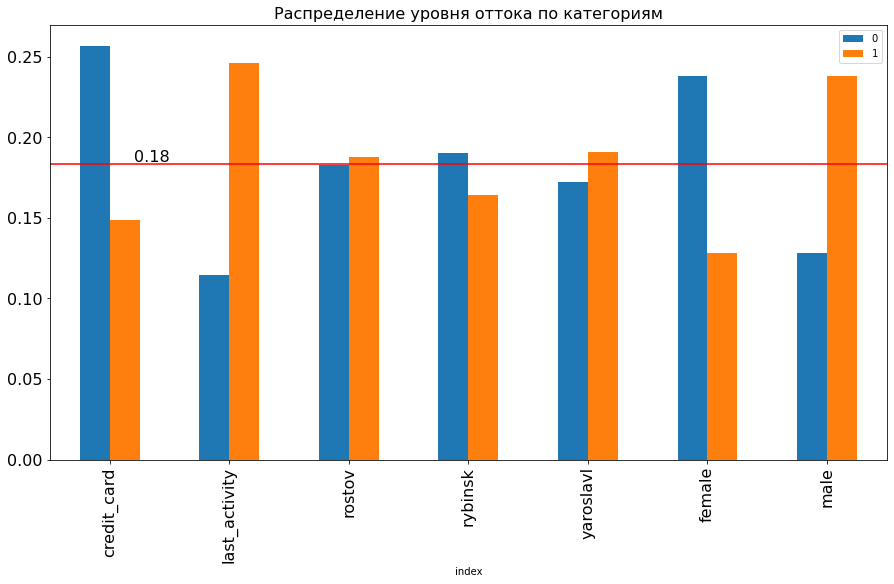

In [50]:
cat_gr.plot(kind='bar', figsize=(15,8), x='index', y=[0,1], fontsize=16)
plt.axhline(y = df['churn'].mean(), color = 'r', linestyle = '-')
plt.text(0.2, 0.185,'{}'.format(round(df['churn'].mean(), 2)), rotation=360, fontsize=16)
plt.legend()
plt.title('Распределение уровня оттока по категориям', fontsize=16);

На данном графике горизонтальня линия соответствует средней величине отскока. Нас интересуют показатели, при которых столбчатые графики пересекают эту линию. Итак, отскок выше среднего у следующих клиентов:

```
- не имеющие кредитной карты;
- активные;
- из городов - Рыбинск и Ярославль;
- мужского пола.
```

Проверим теперь расчетным способом есть ли корреляция с отскоком по критерию Фика.

In [51]:
df1 = df[['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'salary',
          'churn', 'rostov','rybinsk', 'yaroslavl', 'female', 'male']]

interval columns not set, guessing: ['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'salary', 'churn', 'rostov', 'rybinsk', 'yaroslavl', 'female', 'male']


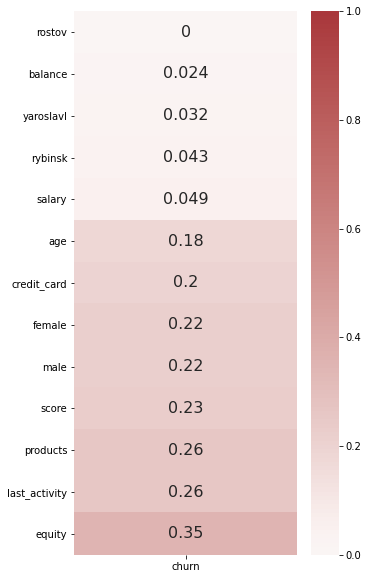

In [52]:
plt.figure(figsize = (5,10))
df2 = df1.phik_matrix()[['churn']].drop(index='churn', axis=0).sort_values(by='churn')
sns.heatmap(df2, annot=True, fmt='.2g',  vmax=1, vmin=0, cmap='vlag', center = 0, annot_kws={"fontsize":16})
sns.set(font_scale=2);

Выше 10% корреляция у столбца `churn` со следующими признаками:
 - score;
 - age;
 - equity;
 - products;
 - credit_card;
 - last_activity;
 - male

Отберем из данных категорий наиболее многочисленные из отточных клиентов c учетом диапазонов полученных на графиках.

In [53]:
df1.query('churn==1 & score.between(820, 940)')['churn'].count()

1375

In [54]:
df1.query('churn==1 & age.between(25, 35)')['churn'].count()

665

In [55]:
df1.query('churn==1 & age.between(50, 61)')['churn'].count()

486

In [56]:
df1.query('churn==1 & balance.between(90000, 250000)')['churn'].count()

187

In [57]:
df1.query('churn==1 & equity>2')['churn'].count()

1470

In [58]:
df1.query('churn==1 & products>2')['churn'].count()

605

In [59]:
df1.query('churn==1 & credit_card==1')['churn'].count()

1003

In [60]:
df1.query('churn==1 & last_activity==1')['churn'].count()

1278

In [61]:
df1.query('churn==1 & male==1')['churn'].count()

1183

[к содержанию](#enter)

<a id='hyp'></a>

### Проверка гипотез

Сформулируем гипотезы для признака `male`: <br/>
H0: доли мужчин среди отточных и неотточных клиентов равны <br/>
H1: доля мужчин среди отточных клиентов не равна доле мужчин среди неотточных 

In [62]:
z_test('male')

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


Величина вероятности раная нулю вызывает сомнения, проверим библиотечной функцией

In [63]:
count = np.array([df1[df1['churn']==0]['male'].sum(), df1[df1['churn']==1]['male'].sum()])
nobs = np.array([df1[df1['churn']==0]['male'].count(), df1[df1['churn']==1]['male'].count()])
stat, pval = proportions_ztest(count, nobs)
print('{0:0.3f}'.format(pval))

0.000


Как видно полученное значение ниже порога статистической значимости, значит нулевая гипотеза не подтвердилась и можно принять что доли отличаются.

Сформулируем гипотезы для признака `credit_card`: <br/>
H0: доли клиентов с кредитными картами среди отточных и неотточных одинаковы <br/>
H1: доля клиентов с кредитными картами среди отточных не равна доле клиентов среди неотточных

In [65]:
z_test('credit_card')

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


Нулевая гипотеза не подтвердилась, доли кредитных карт отличаются

Сформулируем гипотезы для признака `last_activity`: <br/>
H0: доли активных клиентов среди отточных и неотточных одинаковы <br/>
H1: доля активных клиентов среди отточных не равна доле клиентов среди неотточных

In [66]:
z_test('last_activity')

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


Нулевая гипотеза не подтвердилась, доли активных клиентов различаются

Проверим гипотезы для признака `equity`.

Сформулируем гипотезы для признака `equity`:  <br/>
H0: средние оценки собственности среди отточных и неотточных одинаковы <br/>
H1: средняя оценка собственности среди отточных не равна средней оценке неотточных


```
Столбец equity содержит колличественные данные, поэтому для них проверим гипотезы t-тестом. В то же время для корректной оценки должны соблюдаться следующие условия:
- Совокупности не должны зависеть друг от друга (если ind).
- Выборочные средние должны быть нормально распределены.
- Дисперсии рассматриваемых генеральных совокупностей должны быть равны. При этом если выборки достаточно велики (3030 и больше значений) и равны по размеру между собой, то даже если дисперсии на самом деле не равны, то тест редко ошибается.
Однако, наши выборки по размеру существенно отличаются, что может привести к ошибке. Кроме того, параметрические тесты если есть большие выбросы работают плохо. Чтобы проверить достоверность проведем дополнительно непараметрический тест
Уилкоксона-Манна-Уитни, который работает с номерами значений в упорядоченном ряду и не учитывает сами значения.
Поэтому к нему прибегают тогда, когда имеются большие выбросы.
```

In [67]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(df1[df1['churn']==0]['equity'], df1[df1['churn']==1]['equity'], equal_var= False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 8.69455598249367e-196
Отвергаем нулевую гипотезу


In [68]:

alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(df1[df1['churn']==0]['equity'],df1[df1['churn']==1]['equity'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  7.188830962860143e-157
Отвергаем нулевую гипотезу: разница статистически значима


Как видно выводы обоих тестов совпали, однако результаты отличаются на 39 порядков. Хотя данные не содержат выбросов, размеры выборок существенно отличаются, а t-тест как уже отмечалось очень к этому чувствителен, т.к. исходит из того что статистики генерально совокупности имеют нормальное распределение, которое возможно если размеры выборок одинаковые.

Проверим гипотезы для признака `salary`.

Сформулируем гипотезы для признака `salary`:  <br/>
H0: средние доходы отточных и неотточных одинаковы <br/>
H1: средний доход отточных не равен среднему доходу неотточных

In [69]:
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(df1[df1['churn']==0]['salary'], df1[df1['churn']==1]['salary'], equal_var= False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.8796213894730411
Не получилось отвергнуть нулевую гипотезу


In [70]:

alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(df1[df1['churn']==0]['salary'],df1[df1['churn']==1]['salary'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.00022703693954923942
Отвергаем нулевую гипотезу: разница статистически значима


Итак, результаты проверки гипотез для столбца зарплат получились разные, по t-тесту разница средних зарплат статистически не значима, а по тесту mannwhitneyu наоборот. По наличию выбросов и разных размеров выборок условия применения t-теста нарушены, поэтому результат может быть некорректным. Тест mannwhitneyu напротив не подвержен влиянию этих факторов, поэтому нулевую гипотезу можно отвергнуть.

[к содержанию](#enter)

<a id='icon'></a>

## Итоги по EDA

В результате исследовательского анализа были получены следующие результаты:

<img src="./eda concl.png">

На основе таблицы и количественных данных отберем 6 основных признаков влияющих на отток:  <br/>
`male` <br/>
`female` <br/>
`equity` <br/>
`products` <br/>
`credit_card` <br/>
`last_activity` <br/>


[к содержанию](#enter)

<a id='segm'></a>

## Сегментация признаков

На основе отобранных признаков выделим сегмент характерный для отточных клиентов.

In [75]:
qrys = ('male==1 and credit_card==0',
    'equity>2 and last_activity==1',
    'equity>2 and male==1')

df_results = pd.concat([
    pd.DataFrame(df1.query(q).agg({"churn":['mean','count']}).values,
                 columns=[q],
                 index=['Отток','Размер']).T 
    for q in qrys])

display(df_results.style.format("{:.1%}",subset=["Отток"])\
                   .format("{:_.0f}",subset=["Размер"]))
    
all_catched = pd.concat([df1.query(q) for q in qrys])
all_churn = df1.churn.sum()
catched = all_catched.drop_duplicates().churn.sum()
share_catched = catched / all_churn

if len(qrys) != 3:
    print('Результаты некорректны, нужно 3 лучших сегмента')
    
if df_results['Отток'].min() < df1.churn.mean() * 1.5:
    print('Нужно изменить сегменты: присутствуют недостаточно отточные')
elif df_results['Отток'].min() < df1.churn.mean() * 2:
    print('Часть сегментов недостаточно отточна')

if df_results['Размер'].min() < 300:
    print('Нужно изменить сегменты: присутствуют слишком мелкие сегменты')
    
if all_catched.shape[0] > 5000:
    print("Отдел маркетинга не сможет обработать такое количество клиентов")
elif all_catched.shape[0] > 3000:
    print("Отделу маркетинга будет сложно обработать такое количество клиентов, его эффективность снизится")
elif all_catched.shape[0] < 1000:
    print("Сегменты можно увеличить")

text_churn = f"{catched}/{all_churn} = {share_catched:.1%}"
if share_catched < 1/3:
    print(f"В сегменты попало недостаточное число отточных: {text_churn}")
elif share_catched < 1/2:
    print(f"В сегменты попало: {text_churn}")
elif share_catched < 2/3:
    print(f"Хороший результат, в сегменты попало: {text_churn}")
else:
    print(f"Прекрасный результат, в сегменты попало: {text_churn}")

,Отток,Размер
male==1 and credit_card==0,35.2%,1_299
equity>2 and last_activity==1,36.7%,2_915
equity>2 and male==1,35.6%,2_720


Часть сегментов недостаточно отточна
Отдел маркетинга не сможет обработать такое количество клиентов
Прекрасный результат, в сегменты попало: 1424/1819 = 78.3%


<a id='concl'></a>

## Общие выводы

* Получено 3 характерных сегмента отточных клиентов:
 - активные люди с оценкой собственности > 2;
 - мужчины без кредитной карты;
 - мужчины с оценкой собственности > 2	
* Рекомендации по снижению оттока:
```
    - онлайн-оформление полиса страхования имущества в любом регионе России 
    - онлайн-бронирование реквизитов счета, открытие и обслуживание без посещения банка, переводы без коммиссии
    - кобрендинговые карты в магазинах связанных с рыбалкой.    
```

[к содержанию](#enter)

**Ссылка на pdf файл с презентацией**

https://disk.yandex.ru/i/vwhB9Vs-K8nwvg